In [107]:
# import all libraries
import pandas as pd
import numpy as np
import glob
import os
import mne
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

In [73]:
# all functions
# example 1_al_ciplv_theta_1.npy
def parse_filename(filename):
    s = filename.split("_")
    pId = s[0]
    label = s[1]
    method = s[2]
    freq = s[-1].split(".")[0]
    # epoch = s[-1].split(".")[0]
    
    # return {"pId": pId, "label": label, "method": method, "freq": freq, "epoch": epoch}
    return {"pId": pId, "label": label, "method": method, "freq": freq}

def read_file(filename):
    return np.load(filename)

# get all the files in the folder output/
def get_files(folder, filter = None):
    '''
    filter is a dictionary, has 2 keys: method and freq to filter the files
    '''
    files = glob.glob(os.path.join(folder, "*.npy"))
    ret_files = []
    if filter:
        for f in files:
            # get the filename
            filename = os.path.basename(f)
            f_info = parse_filename(filename)
            # remove epoch 2 if no overlap
            # if f_info["epoch"] == "2":
            #     continue
            if (f_info["method"] == filter["method"]) and (f_info["freq"] == filter["freq"]):
                ret_files.append(f)
    else:
        ret_files = files

    return ret_files

def feature_extraction(data):
    """
    get lower part of diagonal matrix
    """
    data_lower = data[np.tril_indices(data.shape[0], k=-1)]
    return data_lower

In [75]:
# logging to airtable
from airtable.airtable import AirTableClient
from airtable.config import config
from pyairtable import Table


atc = AirTableClient(**config["source_space"])

In [96]:
# constants
# get the labels for electrodes
# fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
# subjects_dir = os.path.dirname(fs_dir)
# labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
#                                     subjects_dir=subjects_dir)
# labels.pop(-1)
# label_colors = [label.color for label in labels]
data_source = "no_split2"
labels = {"al": 0, "fa":1}

methods = ['sLORETA']
freqs = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# grid search params for different models
models = {
    "svm": {
        "model": SVC(kernel='linear', C=1),
        "params": {
            "C": [0.1, 1, 10, 100, 1000],
            "kernel": ['linear', 'rbf']
        }
    },
    "logistic": {
        "model": LogisticRegression(solver='liblinear', multi_class='auto'),
        "params": {
            "C": [0.1, 1, 10, 100, 1000],
            "solver": ['liblinear', 'lbfgs']
        }
    },
    # "SGD":{
    #     "model": SGDClassifier(),
    #     "params": {
    #         "loss": ["hinge", "log", "squared_hinge"],
    #         "penalty": ["l2", "l1"],
    #         "alpha": [0.0001, 0.001, 0.01, 0.1, 1]
    #     }
    # },
    # "QDA": {
    #     "model": QuadraticDiscriminantAnalysis(),
    #     "params": {
    #         "reg_param": [0.1, 1, 10, 100]
    #     }
    # },
    # "mlp": {
    #     "model": MLPClassifier(),
    #     "params": {
    #         "hidden_layer_sizes": [(100, 100), (100,100,100)],
    #         "activation": ['tanh', 'relu'],
    #         "solver": ['sgd', 'adam'],
    #         "alpha": [0.0001, 0.05],
    #         "learning_rate": ['constant', 'adaptive'],
    #     }
    # },
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_features": ['sqrt', 'log2'],
            "max_depth": [4, 5, 6],
            "criterion": ['gini', 'entropy']
        }
    },
    # "xgb": {
    #     "model": XGBClassifier(),
    #     "params": {
    #         "learning_rate": [0.05, 0.1, 0.15],
    #         "max_depth": [3, 4, 5, 6, 7],
    #         "gamma": [0.0, 0.1],
    #     }
    # },
    # "ada": {
    #     "model": AdaBoostClassifier(),
    #     "params": {
    #         "n_estimators": [50, 100, 200],
    #         "learning_rate": [0.01, 0.05, 0.1, 0.2]
    #     }
    # },
    # "knn": {
    #     "model": KNeighborsClassifier(),
    #     "params": {
    #         "n_neighbors": [3, 5, 7, 9, 11],
    #         "weights": ['uniform', 'distance'],
    #         "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
    #     }
    # },
    "decision_tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "criterion": ["gini", "entropy"],
            "splitter": ["best", "random"],
            "max_depth": [2, 3, 5],
            "min_samples_split": [2, 3, 5],
            "min_samples_leaf": [2, 3, 5]
        }
    },
}

In [99]:
def run_grid_search(model_name, model, params, X, y):
    """
    run grid search for a model
    """
    grid_search = GridSearchCV(model, params, cv=5, return_train_score=False)
    grid_search.fit(X, y)
    # print("Best params: ", grid_search.best_params_)
    # print("Best score: ", grid_search.best_score_)
    return grid_search.best_params_, grid_search.best_score_

In [108]:
for method in methods:
    for freq in freqs:
        print("Processing: method: {}, freq: {}".format(method, freq))
        filter = {"method": method, "freq": freq}
        files = get_files("output/no_split2/", filter)
        X = []
        Y = []
        for f in files:
            data = read_file(f)
            X.append(feature_extraction(data))
            Y.append(labels.get(parse_filename(os.path.basename(f))["label"]))

        X = np.array(X)
        Y = np.array(Y)
            
        is_feature_selection = True
        # for ifs in [False, True]:
        is_feature_selection = True
        if is_feature_selection:
            lsvc = LogisticRegression().fit(X, Y)
            # model = SelectFromModel(lsvc, prefit=True, threshold=-np.inf, max_features=95)
            rfe = RFE(lsvc, n_features_to_select = 95, step=50)
            rfe.fit(X, Y)
            X_new = rfe.transform(X)
        else:
            X_new = X

        X_new = np.array(X_new)
        Y = np.array(Y)

        X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.5, random_state=12)
        for m in models.keys():
            print("Processing: method: {}, freq: {}, model: {}, feature selection: {}".format(method, freq, m, is_feature_selection))
            best_params, best_score = run_grid_search(m, models[m]["model"], models[m]["params"], X_new, Y)
            # run best model
            model = models[m]["model"].set_params(**best_params)
            model.fit(X_train, Y_train)
            Y_pred = model.predict(X_test)
            score = round(f1_score(Y_test, Y_pred),2)
            # score = round(best_score, 2)
            # print classification report
            print(classification_report(Y_test, Y_pred))
            
            full_classification_report = classification_report(Y_test, Y_pred)

            res = {
                "data": data_source,
                "method": method,
                "frequency": freq,
                "model": m,
                "feature selection": str(is_feature_selection),
                "best_params": str(best_params),
                "accuracy": str(score),
                "full accuracy report": full_classification_report
            }
            atc.add_row(res)


Processing: method: sLORETA, freq: delta
Processing: method: sLORETA, freq: delta, model: svm, feature selection: True
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        27
           1       0.95      0.95      0.95        21

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48

Processing: method: sLORETA, freq: delta, model: logistic, feature selection: True
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       0.91      1.00      0.95        21

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48

Processing: method: sLORETA, freq: delta, model: random_forest, feature selection: True
              precision    recall  f1-score   support

 

45.56

# visualize

In [109]:
at = Table(api_key= config["source_space"]["api_key"], 
            base_id= config["source_space"]["base_id"], 
            table_name= config["source_space"]["table"])

In [110]:
x = pd.DataFrame(at.all())["fields"].values

In [111]:
df_x = pd.DataFrame.from_records(x)
df_x.head()

,id,method,frequency,accuracy,full accuracy report,model,feature selection,data,best_params
0,160,sLORETA,delta,0.27,precision recall f1-score ...,decision_tree,True,no_split2,"{'criterion': 'entropy', 'max_depth': 3, 'min_..."
1,170,sLORETA,beta,0.84,precision recall f1-score ...,logistic,True,no_split2,"{'C': 1, 'solver': 'lbfgs'}"
2,159,sLORETA,delta,0.89,precision recall f1-score ...,random_forest,True,no_split2,"{'criterion': 'gini', 'max_depth': 6, 'max_fea..."
3,172,sLORETA,beta,0.56,precision recall f1-score ...,decision_tree,True,no_split2,"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."
4,157,sLORETA,delta,0.95,precision recall f1-score ...,svm,True,no_split2,"{'C': 1, 'kernel': 'linear'}"


In [112]:
df_x.drop(columns=["full accuracy report", "id", "method", "feature selection", "best_params"], inplace=True)

In [113]:
df_x = df_x[df_x["model"] != "SGD"]
df_x["accuracy"] = df_x["accuracy"].astype(float)*100

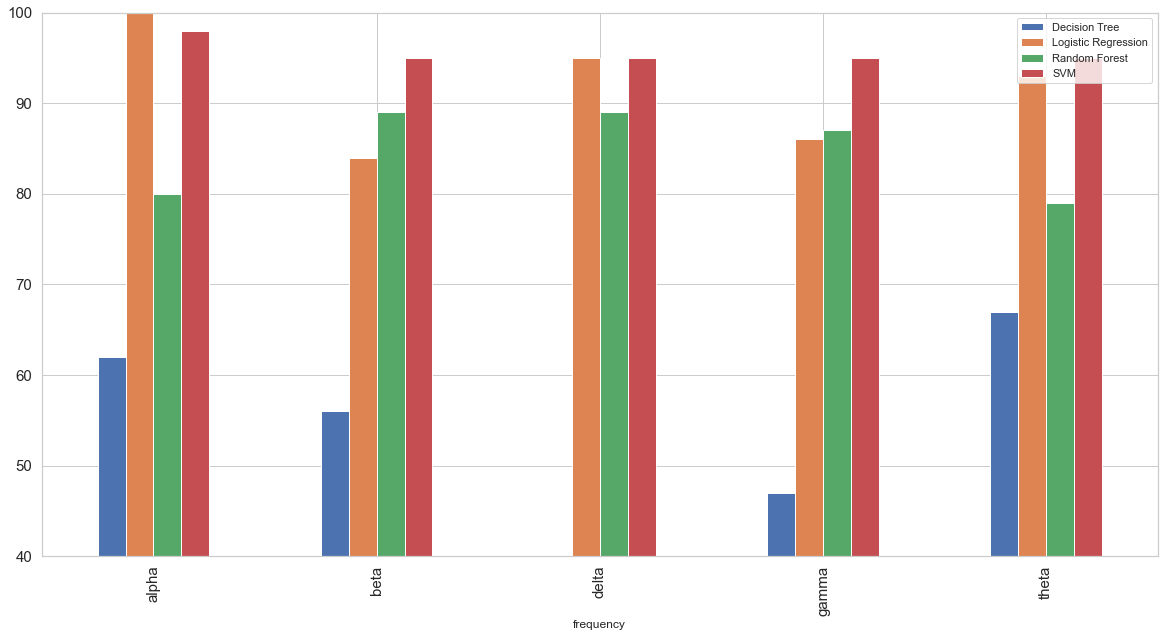

In [114]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df_x.groupby(["frequency", "model"]).mean().unstack()\
    .plot(kind="bar", figsize=(20,10), ylim=[40, 100], ax=ax, fontsize=15)

ax.legend(["Decision Tree", "Logistic Regression", "Random Forest", "SVM"])
